In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

from Notebook_helpers.load_data import *
from Notebook_helpers.modeling_helpers import *

## Load data

In [35]:
df, train, val, test = load_coral_data(complete=True, CV=False, convert_to_categorical=True)

#### Isolate features

In [42]:
# isolate the predictors and labels for both the training and test set
train_X, train_y, pred_names = get_features_and_response(train, with_feature_eng = False)
val_X, val_y, pred_names = get_features_and_response(val, with_feature_eng = False)

train_X = train_X.drop(['Habitat_Modification', 'Invasive_Algae'], axis=1)
val_X = val_X.drop(['Habitat_Modification', 'Invasive_Algae'], axis=1)

In [43]:
print("Using Colums: ", train_X.columns)

Using Colums:  Index(['Effluent', 'Sedimentation', 'New_Development', 'Fishing_Comm_Total',
       'Fishing_NonComm_Boat_Total', 'Fishing_NonComm_Shore_Line',
       'Fishing_NonComm_Shore_Net', 'Fishing_NonComm_Shore_Spear',
       'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M', 'CHL_ANOM_F', 'PAR_CLIM_M',
       'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F', 'Complexity', 'Depth'],
      dtype='object')


#### Standardize

In [44]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
val_X = scaler.transform(val_X.values)

In [45]:
train_y = np.array(train_y, dtype=int)
val_y   = np.array(val_y, dtype=int)

In [46]:
train_X.shape

(396, 18)

In [47]:
def to_0_3(array):
    array = array.copy()
    array[array==1] = 0
    array[array==2] = 1
    array[array==3] = 2
    array[array==5] = 3
    return array
    
def back_to_1_5(array):
    array = array.copy()
    array[array==3] = 5
    array[array==2] = 3
    array[array==1] = 2
    array[array==0] = 1
    return array

In [48]:
print(train_y)
print(to_0_3(train_y))

[3 5 1 5 3 2 1 3 3 1 1 2 2 2 2 5 2 3 2 3 2 5 5 3 1 2 1 5 3 2 1 1 2 5 5 3 1
 3 1 2 5 3 2 2 1 2 3 5 5 2 3 2 1 2 5 1 2 5 3 5 1 3 5 2 5 3 5 1 5 5 1 1 1 1
 5 3 3 2 2 1 5 1 2 1 3 3 2 3 2 1 2 3 5 5 5 3 5 1 2 2 3 1 2 2 5 3 3 5 3 1 5
 2 5 1 3 5 5 1 3 1 3 2 5 1 2 3 1 5 5 1 3 5 1 5 1 2 3 2 3 2 3 5 2 5 2 1 5 5
 1 1 2 2 3 5 3 5 1 3 5 3 5 2 5 5 3 2 3 2 3 2 3 1 3 3 2 1 5 2 2 5 5 5 1 3 2
 5 5 1 2 5 2 3 2 5 2 3 3 1 1 2 1 3 5 3 2 3 2 3 5 5 2 2 5 2 2 2 2 5 1 5 2 3
 1 3 5 1 3 2 1 5 3 2 1 5 2 2 3 5 1 2 5 2 5 3 5 1 1 1 5 3 1 3 2 5 3 1 3 1 3
 2 2 1 1 5 2 2 3 1 1 3 2 2 5 2 2 2 2 2 3 1 5 3 1 2 3 2 1 2 3 1 1 2 5 2 2 1
 1 5 2 5 1 2 5 3 3 3 3 1 1 3 5 5 2 2 5 1 1 1 1 5 1 3 1 2 3 3 1 1 5 2 2 2 3
 5 1 1 2 1 5 1 1 3 5 1 2 1 1 1 2 3 1 2 3 3 1 2 5 2 1 5 5 5 3 5 2 3 1 5 2 3
 2 1 1 3 5 1 2 3 5 1 3 1 2 1 3 1 1 5 2 5 3 3 2 1 3 5]
[2 3 0 3 2 1 0 2 2 0 0 1 1 1 1 3 1 2 1 2 1 3 3 2 0 1 0 3 2 1 0 0 1 3 3 2 0
 2 0 1 3 2 1 1 0 1 2 3 3 1 2 1 0 1 3 0 1 3 2 3 0 2 3 1 3 2 3 0 3 3 0 0 0 0
 3 2 2 1 1 0 3 0 1 0 2 2 1 2 1 0 1 2 3 3 3 2 3

In [49]:
print(val_y)
print(to_0_3(val_y))

[2 2 5 5 2 3 1 1 5 5 5 2 5 5 2 2 1 3 5 3 2 3 5 3 1 1 5 5 2 1 3 1 2 3 2 3 5
 3 1 3 2 2 1 2 1 3 3 1 2 5 1 2 2 2 1 5 5 3 3 2 2 2 1 5 3 1 3 1 3 1 1 3 2 2
 3 5 1 2 1 1 5 3 3 2 5 3 1 1 3 1 2 1 2 1 5 3 5 2 2 3]
[1 1 3 3 1 2 0 0 3 3 3 1 3 3 1 1 0 2 3 2 1 2 3 2 0 0 3 3 1 0 2 0 1 2 1 2 3
 2 0 2 1 1 0 1 0 2 2 0 1 3 0 1 1 1 0 3 3 2 2 1 1 1 0 3 2 0 2 0 2 0 0 2 1 1
 2 3 0 1 0 0 3 2 2 1 3 2 0 0 2 0 1 0 1 0 3 2 3 1 1 2]


## Set up NN

In [50]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 18, 30, 6

# Create random Tensors to hold inputs and outputs.
x = torch.FloatTensor(train_X)
y = torch.from_numpy(to_0_3(train_y))

val = torch.FloatTensor(val_X)
v_y = torch.from_numpy(to_0_3(val_y))

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

## Train NN

In [51]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []
val_loss = []
for t in range(10000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    y_val_pred = model(val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss.append(loss)
    
    loss_v = loss_fn(y_val_pred, v_y)
    val_loss.append(loss_v)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 1.7789000272750854
1 1.7777656316757202
2 1.776631236076355
3 1.7754991054534912
4 1.7743651866912842
5 1.7732354402542114
6 1.772102952003479
7 1.770972490310669
8 1.7698447704315186
9 1.7687174081802368
10 1.767591118812561
11 1.7664647102355957
12 1.7653419971466064
13 1.764219045639038
14 1.7630977630615234
15 1.7619765996932983
16 1.7608574628829956
17 1.7597393989562988
18 1.7586222887039185
19 1.7575052976608276
20 1.7563902139663696
21 1.7552759647369385
22 1.754163384437561
23 1.7530511617660522
24 1.751939058303833
25 1.7508306503295898
26 1.7497222423553467
27 1.74861478805542
28 1.747509241104126
29 1.7464063167572021
30 1.7453001737594604
31 1.744197964668274
32 1.7430965900421143
33 1.7419966459274292
34 1.740897297859192
35 1.739800214767456
36 1.7387059926986694
37 1.737612009048462
38 1.7365206480026245
39 1.7354284524917603
40 1.7343382835388184
41 1.733249545097351
42 1.7321604490280151
43 1.7310724258422852
44 1.7299867868423462
45 1.7288992404937744
46 1.72781443

556 1.2565815448760986
557 1.2558608055114746
558 1.2551403045654297
559 1.254421353340149
560 1.253702998161316
561 1.2529842853546143
562 1.2522685527801514
563 1.2515530586242676
564 1.250839114189148
565 1.2501274347305298
566 1.2494149208068848
567 1.2487046718597412
568 1.2479948997497559
569 1.2472864389419556
570 1.2465792894363403
571 1.2458730936050415
572 1.2451667785644531
573 1.2444616556167603
574 1.2437573671340942
575 1.2430540323257446
576 1.2423512935638428
577 1.2416493892669678
578 1.240949273109436
579 1.240248441696167
580 1.2395479679107666
581 1.238849401473999
582 1.2381513118743896
583 1.2374547719955444
584 1.2367583513259888
585 1.236063838005066
586 1.2353712320327759
587 1.2346794605255127
588 1.2339884042739868
589 1.233298420906067
590 1.2326092720031738
591 1.231920838356018
592 1.2312339544296265
593 1.230547308921814
594 1.2298622131347656
595 1.2291786670684814
596 1.2284947633743286
597 1.2278130054473877
598 1.2271307706832886
599 1.226449370384216

942 1.0475659370422363
943 1.047182321548462
944 1.0467981100082397
945 1.0464152097702026
946 1.0460317134857178
947 1.0456501245498657
948 1.0452688932418823
949 1.0448882579803467
950 1.0445082187652588
951 1.044127345085144
952 1.0437486171722412
953 1.043370008468628
954 1.0429919958114624
955 1.042614221572876
956 1.042237639427185
957 1.041860818862915
958 1.0414849519729614
959 1.0411094427108765
960 1.0407356023788452
961 1.0403616428375244
962 1.0399885177612305
963 1.039615273475647
964 1.0392427444458008
965 1.038870930671692
966 1.0384999513626099
967 1.038129210472107
968 1.0377585887908936
969 1.0373889207839966
970 1.0370192527770996
971 1.036650538444519
972 1.0362821817398071
973 1.0359147787094116
974 1.0355479717254639
975 1.0351808071136475
976 1.0348149538040161
977 1.0344494581222534
978 1.0340839624404907
979 1.0337202548980713
980 1.0333565473556519
981 1.0329930782318115
982 1.0326303243637085
983 1.0322678089141846
984 1.0319067239761353
985 1.031545519828796

1293 0.9380427598953247
1294 0.9377830624580383
1295 0.9375249147415161
1296 0.9372673630714417
1297 0.9370098114013672
1298 0.9367521405220032
1299 0.9364945292472839
1300 0.9362371563911438
1301 0.9359800815582275
1302 0.9357233643531799
1303 0.9354673624038696
1304 0.9352111220359802
1305 0.9349539279937744
1306 0.9346985220909119
1307 0.9344430565834045
1308 0.9341872930526733
1309 0.9339326620101929
1310 0.9336779713630676
1311 0.9334232211112976
1312 0.9331696033477783
1313 0.9329144954681396
1314 0.9326608777046204
1315 0.9324073195457458
1316 0.9321521520614624
1317 0.9318983554840088
1318 0.9316453337669373
1319 0.9313912987709045
1320 0.9311384558677673
1321 0.9308847784996033
1322 0.9306321740150452
1323 0.9303797483444214
1324 0.9301270246505737
1325 0.9298750758171082
1326 0.929622232913971
1327 0.9293704628944397
1328 0.9291186332702637
1329 0.928867757320404
1330 0.9286167025566101
1331 0.9283657073974609
1332 0.9281151294708252
1333 0.9278650283813477
1334 0.92761498689

1660 0.8557332158088684
1661 0.8555405735969543
1662 0.8553475141525269
1663 0.8551546335220337
1664 0.8549630641937256
1665 0.854769766330719
1666 0.8545781373977661
1667 0.8543856739997864
1668 0.8541946411132812
1669 0.8540024161338806
1670 0.853810727596283
1671 0.8536187410354614
1672 0.8534283638000488
1673 0.8532368540763855
1674 0.8530461192131042
1675 0.8528558015823364
1676 0.8526650071144104
1677 0.85247403383255
1678 0.85228431224823
1679 0.8520937561988831
1680 0.8519036769866943
1681 0.8517131805419922
1682 0.8515236377716064
1683 0.8513342142105103
1684 0.8511449098587036
1685 0.850955605506897
1686 0.8507669568061829
1687 0.8505783081054688
1688 0.8503894805908203
1689 0.8502005934715271
1690 0.8500121235847473
1691 0.8498246669769287
1692 0.8496366739273071
1693 0.8494486808776855
1694 0.8492618203163147
1695 0.8490745425224304
1696 0.8488869667053223
1697 0.8487007021903992
1698 0.8485139608383179
1699 0.8483279347419739
1700 0.8481415510177612
1701 0.847955584526062


2182 0.7716580033302307
2183 0.7715227603912354
2184 0.77138751745224
2185 0.7712520360946655
2186 0.7711169123649597
2187 0.7709813117980957
2188 0.7708461284637451
2189 0.7707106471061707
2190 0.7705757021903992
2191 0.7704397439956665
2192 0.7703042030334473
2193 0.7701681852340698
2194 0.7700339555740356
2195 0.7698987126350403
2196 0.7697635889053345
2197 0.7696288824081421
2198 0.769494354724884
2199 0.7693597674369812
2200 0.7692252397537231
2201 0.7690906524658203
2202 0.7689562439918518
2203 0.768821656703949
2204 0.7686874866485596
2205 0.7685530185699463
2206 0.7684190273284912
2207 0.7682846784591675
2208 0.7681506872177124
2209 0.7680163979530334
2210 0.767882764339447
2211 0.7677486538887024
2212 0.7676153182983398
2213 0.7674822807312012
2214 0.7673484683036804
2215 0.7672155499458313
2216 0.7670825719833374
2217 0.7669500708580017
2218 0.7668172121047974
2219 0.7666838765144348
2220 0.7665509581565857
2221 0.7664182782173157
2222 0.7662859559059143
2223 0.76615297794342

2539 0.7277422547340393
2540 0.7276270985603333
2541 0.727512776851654
2542 0.7273977398872375
2543 0.7272830605506897
2544 0.7271682024002075
2545 0.7270535826683044
2546 0.7269391417503357
2547 0.7268240451812744
2548 0.7267093062400818
2549 0.726595401763916
2550 0.7264804244041443
2551 0.7263656258583069
2552 0.7262510061264038
2553 0.726135790348053
2554 0.7260211706161499
2555 0.7259063124656677
2556 0.7257917523384094
2557 0.7256770133972168
2558 0.7255620360374451
2559 0.7254475951194763
2560 0.7253325581550598
2561 0.7252180576324463
2562 0.7251029014587402
2563 0.7249879240989685
2564 0.7248729467391968
2565 0.7247592806816101
2566 0.7246448397636414
2567 0.7245308756828308
2568 0.724416196346283
2569 0.7243021726608276
2570 0.7241881489753723
2571 0.7240739464759827
2572 0.7239598631858826
2573 0.7238460779190063
2574 0.7237318158149719
2575 0.7236177921295166
2576 0.723503828048706
2577 0.7233903408050537
2578 0.7232764363288879
2579 0.7231625914573669
2580 0.72304922342300

2901 0.6889280080795288
2902 0.6888309121131897
2903 0.6887325048446655
2904 0.6886345744132996
2905 0.6885362863540649
2906 0.6884387731552124
2907 0.6883408427238464
2908 0.6882427334785461
2909 0.6881451606750488
2910 0.6880480051040649
2911 0.6879503726959229
2912 0.6878528594970703
2913 0.6877557039260864
2914 0.6876587271690369
2915 0.6875615119934082
2916 0.6874644756317139
2917 0.6873670816421509
2918 0.6872705221176147
2919 0.6871739625930786
2920 0.6870771646499634
2921 0.6869801878929138
2922 0.6868836879730225
2923 0.6867872476577759
2924 0.6866911053657532
2925 0.6865939497947693
2926 0.6864975690841675
2927 0.6864011883735657
2928 0.6863048672676086
2929 0.6862080693244934
2930 0.6861124634742737
2931 0.686015784740448
2932 0.6859190464019775
2933 0.6858233213424683
2934 0.6857270002365112
2935 0.685630738735199
2936 0.6855345368385315
2937 0.6854379773139954
2938 0.6853421926498413
2939 0.685245931148529
2940 0.6851495504379272
2941 0.6850537657737732
2942 0.684958040714

3251 0.6561670303344727
3252 0.6560760140419006
3253 0.6559856534004211
3254 0.6558954119682312
3255 0.6558043956756592
3256 0.6557139158248901
3257 0.6556243300437927
3258 0.6555338501930237
3259 0.6554436683654785
3260 0.6553532481193542
3261 0.6552631855010986
3262 0.6551731824874878
3263 0.6550832986831665
3264 0.6549937129020691
3265 0.6549042463302612
3266 0.6548146605491638
3267 0.654724657535553
3268 0.6546347737312317
3269 0.6545456647872925
3270 0.654456615447998
3271 0.6543671488761902
3272 0.6542776823043823
3273 0.6541887521743774
3274 0.6540989875793457
3275 0.6540098190307617
3276 0.6539201736450195
3277 0.6538317203521729
3278 0.6537423133850098
3279 0.6536527872085571
3280 0.6535630822181702
3281 0.6534739136695862
3282 0.653384268283844
3283 0.6532952785491943
3284 0.6532062292098999
3285 0.6531167030334473
3286 0.6530280709266663
3287 0.6529387831687927
3288 0.6528493165969849
3289 0.6527605652809143
3290 0.6526719927787781
3291 0.6525832414627075
3292 0.652494311332

3762 0.6091290712356567
3763 0.6090410947799683
3764 0.608952522277832
3765 0.60886549949646
3766 0.6087771654129028
3767 0.6086899042129517
3768 0.6086022257804871
3769 0.6085147857666016
3770 0.6084273457527161
3771 0.6083396077156067
3772 0.6082513332366943
3773 0.6081642508506775
3774 0.6080770492553711
3775 0.6079898476600647
3776 0.6079028248786926
3777 0.6078156232833862
3778 0.6077283024787903
3779 0.6076407432556152
3780 0.607552707195282
3781 0.6074659824371338
3782 0.6073785424232483
3783 0.6072909235954285
3784 0.6072037220001221
3785 0.6071161031723022
3786 0.6070286631584167
3787 0.6069410443305969
3788 0.6068536639213562
3789 0.6067659258842468
3790 0.606678307056427
3791 0.606591522693634
3792 0.606503963470459
3793 0.6064176559448242
3794 0.6063308119773865
3795 0.6062443256378174
3796 0.6061583757400513
3797 0.6060721278190613
3798 0.6059859395027161
3799 0.6058998703956604
3800 0.6058135628700256
3801 0.6057271361351013
3802 0.6056413650512695
3803 0.6055557727813721

4264 0.5649707913398743
4265 0.5648863315582275
4266 0.5648018717765808
4267 0.564717173576355
4268 0.5646324157714844
4269 0.5645477771759033
4270 0.5644636154174805
4271 0.5643784403800964
4272 0.564293384552002
4273 0.5642088651657104
4274 0.5641232132911682
4275 0.5640389323234558
4276 0.5639540553092957
4277 0.5638698935508728
4278 0.5637850165367126
4279 0.5637001395225525
4280 0.5636152625083923
4281 0.5635301470756531
4282 0.5634462237358093
4283 0.5633611083030701
4284 0.5632757544517517
4285 0.5631906986236572
4286 0.5631054043769836
4287 0.5630205273628235
4288 0.5629356503486633
4289 0.5628498196601868
4290 0.5627645254135132
4291 0.5626786947250366
4292 0.5625936985015869
4293 0.5625091195106506
4294 0.5624236464500427
4295 0.5623388886451721
4296 0.5622534155845642
4297 0.5621679425239563
4298 0.5620825290679932
4299 0.5619972348213196
4300 0.5619122385978699
4301 0.5618272423744202
4302 0.5617423057556152
4303 0.5616574287414551
4304 0.5615721940994263
4305 0.56148737668

4776 0.5212627649307251
4777 0.5211754441261292
4778 0.5210877060890198
4779 0.5210002064704895
4780 0.5209135413169861
4781 0.5208267569541931
4782 0.5207390785217285
4783 0.5206517577171326
4784 0.52056485414505
4785 0.5204774737358093
4786 0.5203906297683716
4787 0.5203036069869995
4788 0.5202163457870483
4789 0.5201295614242554
4790 0.5200416445732117
4791 0.5199539661407471
4792 0.5198655724525452
4793 0.5197772979736328
4794 0.519688069820404
4795 0.519599199295044
4796 0.5195098519325256
4797 0.519420862197876
4798 0.5193321704864502
4799 0.519242525100708
4800 0.5191529393196106
4801 0.5190640091896057
4802 0.5189746618270874
4803 0.5188860893249512
4804 0.5187970399856567
4805 0.5187088847160339
4806 0.5186200141906738
4807 0.5185309648513794
4808 0.5184417366981506
4809 0.5183526277542114
4810 0.5182636976242065
4811 0.5181746482849121
4812 0.5180860161781311
4813 0.5179972648620605
4814 0.517907977104187
4815 0.5178197026252747
4816 0.5177310109138489
4817 0.5176421403884888

5123 0.49053695797920227
5124 0.49044930934906006
5125 0.49036237597465515
5126 0.49027499556541443
5127 0.49018752574920654
5128 0.49010002613067627
5129 0.4900130331516266
5130 0.4899260699748993
5131 0.4898388385772705
5132 0.4897511899471283
5133 0.4896644055843353
5134 0.4895768463611603
5135 0.4894896149635315
5136 0.4894026517868042
5137 0.489315390586853
5138 0.48922792077064514
5139 0.4891415536403656
5140 0.48905497789382935
5141 0.4889672100543976
5142 0.4888800382614136
5143 0.48879358172416687
5144 0.48870664834976196
5145 0.48861929774284363
5146 0.4885324537754059
5147 0.4884452819824219
5148 0.4883583188056946
5149 0.4882716238498688
5150 0.4881853759288788
5151 0.4880995750427246
5152 0.48801302909851074
5153 0.48792609572410583
5154 0.48783940076828003
5155 0.4877529442310333
5156 0.4876667857170105
5157 0.48758038878440857
5158 0.4874938726425171
5159 0.48740729689598083
5160 0.48732078075408936
5161 0.4872349202632904
5162 0.48714882135391235
5163 0.487062007188797


5466 0.4612247943878174
5467 0.46114280819892883
5468 0.4610603153705597
5469 0.4609783887863159
5470 0.4608966112136841
5471 0.46081408858299255
5472 0.4607311189174652
5473 0.46064919233322144
5474 0.46056613326072693
5475 0.46048417687416077
5476 0.4604019820690155
5477 0.4603199064731598
5478 0.4602374732494354
5479 0.46015509963035583
5480 0.46007272601127625
5481 0.45999065041542053
5482 0.4599078893661499
5483 0.45982658863067627
5484 0.4597441852092743
5485 0.4596615731716156
5486 0.45957911014556885
5487 0.45949628949165344
5488 0.4594145119190216
5489 0.4593324661254883
5490 0.45925024151802063
5491 0.45916748046875
5492 0.45908549427986145
5493 0.4590037167072296
5494 0.4589209258556366
5495 0.4588387906551361
5496 0.45875585079193115
5497 0.4586736559867859
5498 0.45859089493751526
5499 0.4585078954696655
5500 0.45842596888542175
5501 0.45834288001060486
5502 0.45826011896133423
5503 0.45817747712135315
5504 0.4580960273742676
5505 0.45801281929016113
5506 0.457929164171218

5808 0.4338048994541168
5809 0.4337274134159088
5810 0.4336496889591217
5811 0.4335724115371704
5812 0.4334954619407654
5813 0.43341779708862305
5814 0.43334081768989563
5815 0.4332638680934906
5816 0.43318650126457214
5817 0.43310967087745667
5818 0.4330326020717621
5819 0.4329550862312317
5820 0.4328787326812744
5821 0.4328013062477112
5822 0.43272438645362854
5823 0.4326472878456116
5824 0.43257051706314087
5825 0.43249306082725525
5826 0.4324153661727905
5827 0.4323388636112213
5828 0.43226203322410583
5829 0.43218445777893066
5830 0.4321070909500122
5831 0.43202999234199524
5832 0.43195274472236633
5833 0.4318760931491852
5834 0.43179917335510254
5835 0.43172207474708557
5836 0.43164506554603577
5837 0.43156811594963074
5838 0.4314913749694824
5839 0.431414932012558
5840 0.43133798241615295
5841 0.43126043677330017
5842 0.43118369579315186
5843 0.4311075806617737
5844 0.4310297966003418
5845 0.43095359206199646
5846 0.4308762550354004
5847 0.4307999908924103
5848 0.430723398923873

6316 0.3946116268634796
6317 0.39453190565109253
6318 0.3944537341594696
6319 0.39437541365623474
6320 0.3942955732345581
6321 0.39421650767326355
6322 0.39413750171661377
6323 0.39405784010887146
6324 0.3939785957336426
6325 0.39389878511428833
6326 0.39382022619247437
6327 0.39374086260795593
6328 0.39366158843040466
6329 0.3935829997062683
6330 0.3935035467147827
6331 0.39342403411865234
6332 0.3933444619178772
6333 0.3932651877403259
6334 0.3931865096092224
6335 0.3931070864200592
6336 0.39302799105644226
6337 0.39295002818107605
6338 0.3928698003292084
6339 0.3927905857563019
6340 0.39271095395088196
6341 0.3926312327384949
6342 0.3925500214099884
6343 0.39247050881385803
6344 0.39239010214805603
6345 0.39230963587760925
6346 0.392228901386261
6347 0.39214783906936646
6348 0.3920670449733734
6349 0.3919863700866699
6350 0.391905277967453
6351 0.3918251395225525
6352 0.3917446732521057
6353 0.3916637897491455
6354 0.3915826678276062
6355 0.39150190353393555
6356 0.3914211690425873


6662 0.3674266040325165
6663 0.36734825372695923
6664 0.3672683835029602
6665 0.3671908974647522
6666 0.3671128749847412
6667 0.3670346438884735
6668 0.36695626378059387
6669 0.3668766915798187
6670 0.36679720878601074
6671 0.36671775579452515
6672 0.3666394054889679
6673 0.3665604591369629
6674 0.36648011207580566
6675 0.36640143394470215
6676 0.3663215637207031
6677 0.36624181270599365
6678 0.36616310477256775
6679 0.3660838305950165
6680 0.3660048544406891
6681 0.36592552065849304
6682 0.36584579944610596
6683 0.3657664656639099
6684 0.3656865656375885
6685 0.3656066060066223
6686 0.3655281364917755
6687 0.36544904112815857
6688 0.36536911129951477
6689 0.36528992652893066
6690 0.3652115762233734
6691 0.36513152718544006
6692 0.3650522828102112
6693 0.3649751543998718
6694 0.3648979067802429
6695 0.36481973528862
6696 0.36474162340164185
6697 0.3646640479564667
6698 0.36458665132522583
6699 0.3645091950893402
6700 0.36443182826042175
6701 0.3643535375595093
6702 0.3642745018005371
6

7003 0.34140580892562866
7004 0.3413347601890564
7005 0.341263085603714
7006 0.3411910831928253
7007 0.3411206305027008
7008 0.3410491943359375
7009 0.34097737073898315
7010 0.3409057855606079
7011 0.34083491563796997
7012 0.34076371788978577
7013 0.34069254994392395
7014 0.34062209725379944
7015 0.3405502140522003
7016 0.34047919511795044
7017 0.3404092490673065
7018 0.3403374254703522
7019 0.340267151594162
7020 0.3401957154273987
7021 0.3401249349117279
7022 0.34005483984947205
7023 0.3399830460548401
7024 0.3399122357368469
7025 0.33984148502349854
7026 0.3397708535194397
7027 0.3396996259689331
7028 0.33962878584861755
7029 0.3395580053329468
7030 0.3394867777824402
7031 0.33941635489463806
7032 0.33934450149536133
7033 0.33927425742149353
7034 0.339202880859375
7035 0.33913174271583557
7036 0.3390606641769409
7037 0.3389895260334015
7038 0.3389193117618561
7039 0.33884814381599426
7040 0.3387768268585205
7041 0.3387058675289154
7042 0.33863556385040283
7043 0.33856475353240967
70

7343 0.3171568214893341
7344 0.3170873522758484
7345 0.31701838970184326
7346 0.316947340965271
7347 0.3168780505657196
7348 0.3168087899684906
7349 0.3167394697666168
7350 0.3166702389717102
7351 0.3166005313396454
7352 0.31653091311454773
7353 0.3164612054824829
7354 0.3163914084434509
7355 0.3163210451602936
7356 0.31625211238861084
7357 0.31618353724479675
7358 0.3161134123802185
7359 0.31604358553886414
7360 0.3159749507904053
7361 0.31590625643730164
7362 0.3158363699913025
7363 0.31576797366142273
7364 0.31569957733154297
7365 0.3156301975250244
7366 0.3155609667301178
7367 0.3154917359352112
7368 0.3154231309890747
7369 0.3153531551361084
7370 0.3152845501899719
7371 0.3152160346508026
7372 0.3151465952396393
7373 0.31507760286331177
7374 0.3150087296962738
7375 0.3149401843547821
7376 0.31487077474594116
7377 0.3148019313812256
7378 0.3147335946559906
7379 0.31466472148895264
7380 0.31459635496139526
7381 0.3145274817943573
7382 0.31445810198783875
7383 0.3143902122974396
7384

7692 0.2943989038467407
7693 0.29433757066726685
7694 0.29427531361579895
7695 0.29421266913414
7696 0.2941507399082184
7697 0.2940889000892639
7698 0.2940283417701721
7699 0.29396742582321167
7700 0.29390576481819153
7701 0.29384467005729675
7702 0.29378437995910645
7703 0.29372233152389526
7704 0.2936606705188751
7705 0.2935997247695923
7706 0.29353851079940796
7707 0.2934764623641968
7708 0.29341521859169006
7709 0.2933543026447296
7710 0.29329219460487366
7711 0.29323020577430725
7712 0.29316896200180054
7713 0.2931082546710968
7714 0.2930462062358856
7715 0.2929844260215759
7716 0.2929219603538513
7717 0.2928597927093506
7718 0.29279738664627075
7719 0.2927357256412506
7720 0.2926742136478424
7721 0.2926112413406372
7722 0.2925489842891693
7723 0.2924872636795044
7724 0.2924252152442932
7725 0.29236283898353577
7726 0.2923007309436798
7727 0.2922385036945343
7728 0.2921757102012634
7729 0.29211390018463135
7730 0.2920525372028351
7731 0.2919909358024597
7732 0.29192885756492615
77

8036 0.27367186546325684
8037 0.2736152410507202
8038 0.2735580801963806
8039 0.2735014855861664
8040 0.27344465255737305
8041 0.27338841557502747
8042 0.2733309864997864
8043 0.2732749879360199
8044 0.27321746945381165
8045 0.27316024899482727
8046 0.2731040418148041
8047 0.273047536611557
8048 0.27299076318740845
8049 0.2729337811470032
8050 0.2728770971298218
8051 0.27282026410102844
8052 0.2727636694908142
8053 0.2727075219154358
8054 0.2726505398750305
8055 0.2725932002067566
8056 0.27253639698028564
8057 0.27248042821884155
8058 0.27242448925971985
8059 0.27236708998680115
8060 0.2723112106323242
8061 0.27225497364997864
8062 0.27219828963279724
8063 0.272140771150589
8064 0.27208560705184937
8065 0.27202925086021423
8066 0.2719712555408478
8067 0.2719142735004425
8068 0.27185824513435364
8069 0.27180173993110657
8070 0.27174460887908936
8071 0.2716872990131378
8072 0.27163073420524597
8073 0.2715742588043213
8074 0.2715180814266205
8075 0.27146196365356445
8076 0.271404743194580

8389 0.2546336352825165
8390 0.2545822858810425
8391 0.2545311152935028
8392 0.25447961688041687
8393 0.2544277310371399
8394 0.2543754279613495
8395 0.25432413816452026
8396 0.25427255034446716
8397 0.2542220652103424
8398 0.2541709840297699
8399 0.25411903858184814
8400 0.25406748056411743
8401 0.2540152370929718
8402 0.25396448373794556
8403 0.2539135813713074
8404 0.25386208295822144
8405 0.2538111209869385
8406 0.2537592351436615
8407 0.25370854139328003
8408 0.2536582350730896
8409 0.2536075711250305
8410 0.2535557150840759
8411 0.25350406765937805
8412 0.25345340371131897
8413 0.25340187549591064
8414 0.25335124135017395
8415 0.25329992175102234
8416 0.2532491683959961
8417 0.2531976103782654
8418 0.253146767616272
8419 0.25309592485427856
8420 0.2530447542667389
8421 0.2529933750629425
8422 0.2529429793357849
8423 0.2528912425041199
8424 0.25284045934677124
8425 0.25279009342193604
8426 0.25273919105529785
8427 0.2526888847351074
8428 0.2526383399963379
8429 0.2525866627693176


8743 0.23736533522605896
8744 0.23731927573680878
8745 0.23727267980575562
8746 0.23722708225250244
8747 0.23718109726905823
8748 0.2371339648962021
8749 0.23708777129650116
8750 0.23704178631305695
8751 0.23699437081813812
8752 0.23694834113121033
8753 0.23690205812454224
8754 0.23685599863529205
8755 0.23681040108203888
8756 0.23676396906375885
8757 0.23671747744083405
8758 0.23667103052139282
8759 0.23662468791007996
8760 0.23657849431037903
8761 0.23653268814086914
8762 0.2364855855703354
8763 0.23644007742404938
8764 0.23639467358589172
8765 0.23634792864322662
8766 0.2363019585609436
8767 0.23625551164150238
8768 0.23620912432670593
8769 0.2361629754304886
8770 0.23611818253993988
8771 0.2360711544752121
8772 0.23602339625358582
8773 0.2359774112701416
8774 0.23593194782733917
8775 0.23588642477989197
8776 0.23583924770355225
8777 0.235792875289917
8778 0.23574693500995636
8779 0.23570100963115692
8780 0.23565421998500824
8781 0.23560866713523865
8782 0.23556353151798248
8783 0.2

9120 0.22057610750198364
9121 0.2205335795879364
9122 0.22049133479595184
9123 0.22044913470745087
9124 0.22040660679340363
9125 0.22036467492580414
9126 0.22032290697097778
9127 0.22027923166751862
9128 0.2202373445034027
9129 0.22019515931606293
9130 0.22015313804149628
9131 0.22011017799377441
9132 0.22006797790527344
9133 0.22002622485160828
9134 0.2199835479259491
9135 0.21994104981422424
9136 0.21989847719669342
9137 0.21985726058483124
9138 0.2198149561882019
9139 0.21977286040782928
9140 0.21973153948783875
9141 0.21968893706798553
9142 0.2196456640958786
9143 0.2196040153503418
9144 0.21956272423267365
9145 0.2195201963186264
9146 0.21947795152664185
9147 0.2194356471300125
9148 0.21939389407634735
9149 0.21935060620307922
9150 0.21930955350399017
9151 0.21926777064800262
9152 0.21922440826892853
9153 0.2191828340291977
9154 0.21914102137088776
9155 0.2190970778465271
9156 0.21905340254306793
9157 0.21901090443134308
9158 0.21896813809871674
9159 0.21892336010932922
9160 0.218

9489 0.20524895191192627
9490 0.20520876348018646
9491 0.20516960322856903
9492 0.2051294893026352
9493 0.20508995652198792
9494 0.2050502449274063
9495 0.205010786652565
9496 0.20497122406959534
9497 0.20493189990520477
9498 0.20489256083965302
9499 0.20485250651836395
9500 0.2048129141330719
9501 0.2047727108001709
9502 0.20473363995552063
9503 0.20469488203525543
9504 0.20465455949306488
9505 0.20461399853229523
9506 0.2045762836933136
9507 0.20453691482543945
9508 0.20449692010879517
9509 0.20445822179317474
9510 0.2044178694486618
9511 0.20437905192375183
9512 0.2043399214744568
9513 0.20430056750774384
9514 0.20426085591316223
9515 0.2042219638824463
9516 0.20418252050876617
9517 0.20414236187934875
9518 0.20410235226154327
9519 0.20406275987625122
9520 0.20402397215366364
9521 0.20398376882076263
9522 0.20394454896450043
9523 0.20390556752681732
9524 0.20386667549610138
9525 0.20382721722126007
9526 0.20378749072551727
9527 0.20374839007854462
9528 0.20370905101299286
9529 0.203

9869 0.1904093623161316
9870 0.19037200510501862
9871 0.1903340071439743
9872 0.1902962177991867
9873 0.19025905430316925
9874 0.19022095203399658
9875 0.19018343091011047
9876 0.19014517962932587
9877 0.19010847806930542
9878 0.19007058441638947
9879 0.19003193080425262
9880 0.1899939775466919
9881 0.18995670974254608
9882 0.18992024660110474
9883 0.18988218903541565
9884 0.18984562158584595
9885 0.1898079365491867
9886 0.1897687464952469
9887 0.18973128497600555
9888 0.1896936446428299
9889 0.18965499103069305
9890 0.18961776793003082
9891 0.1895805448293686
9892 0.18954269587993622
9893 0.18950515985488892
9894 0.18946847319602966
9895 0.18943174183368683
9896 0.18939313292503357
9897 0.18935459852218628
9898 0.18931739032268524
9899 0.18927974998950958
9900 0.18924294412136078
9901 0.18920522928237915
9902 0.18916654586791992
9903 0.18912889063358307
9904 0.18909218907356262
9905 0.18905490636825562
9906 0.18901674449443817
9907 0.18897902965545654
9908 0.18894144892692566
9909 0.1

In [52]:
scores = model(torch.FloatTensor(train_X))
scores_np = scores.detach().numpy()

estimates = np.argmax(scores_np, axis=1)

Misclassified samples: 20
Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.96      0.98       104
           2       0.93      0.97      0.95       103
           3       0.94      0.92      0.93        95
           5       0.94      0.95      0.94        94

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



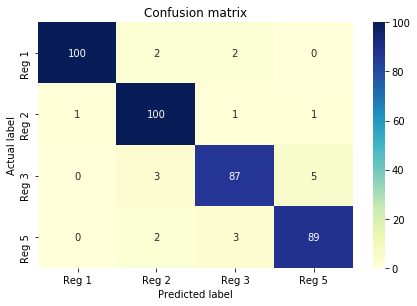

In [53]:
evaluate_performance(back_to_1_5(estimates), train_y)

### Validation

In [54]:
val_scores = model(torch.FloatTensor(val_X))
val_scores_np = val_scores.detach().numpy()

val_estimates = np.argmax(val_scores_np, axis=1)

Misclassified samples: 41
Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.63      0.64        27
           2       0.61      0.59      0.60        29
           3       0.64      0.55      0.59        29
           5       0.43      0.60      0.50        15

    accuracy                           0.59       100
   macro avg       0.58      0.59      0.58       100
weighted avg       0.60      0.59      0.59       100



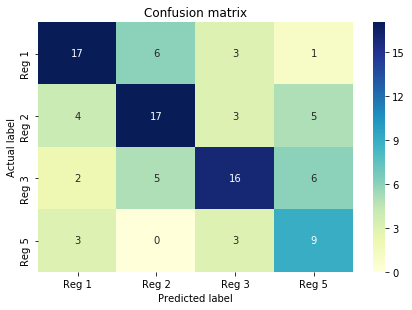

In [55]:
evaluate_performance(back_to_1_5(val_estimates), val_y)

### Bias-Variance Tradeoff

Text(0.5, 1.0, 'Training Loss')

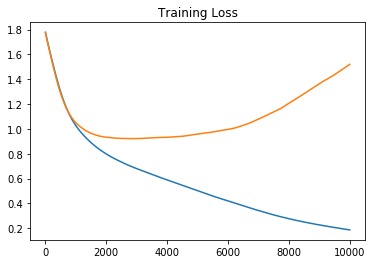

In [56]:
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title("Training Loss")

In [57]:
np.argmin(val_loss)

2758

## Retrain for the optimal number of epochs

In [58]:
# Use the nn package to define our model and loss function.
model2 = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

In [59]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=0.1)
train_loss = []
val_loss = []
for t in range(2500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model2(x)
#     y_val_pred = model2(val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss.append(loss)
    
#     loss_v = loss_fn(y_val_pred, v_y)
#     val_loss.append(loss_v)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 1.856705665588379
1 1.8557138442993164
2 1.854722023010254
3 1.853734016418457
4 1.8527473211288452
5 1.8517624139785767
6 1.8507784605026245
7 1.8497976064682007
8 1.8488171100616455
9 1.8478405475616455
10 1.8468637466430664
11 1.8458895683288574
12 1.8449171781539917
13 1.8439472913742065
14 1.8429781198501587
15 1.8420114517211914
16 1.841049313545227
17 1.8400874137878418
18 1.8391287326812744
19 1.8381725549697876
20 1.8372169733047485
21 1.836264729499817
22 1.835314154624939
23 1.8343665599822998
24 1.8334203958511353
25 1.832476258277893
26 1.8315356969833374
27 1.8305957317352295
28 1.8296583890914917
29 1.8287222385406494
30 1.827788233757019
31 1.8268580436706543
32 1.8259280920028687
33 1.8250001668930054
34 1.8240749835968018
35 1.8231507539749146
36 1.8222286701202393
37 1.8213106393814087
38 1.8203926086425781
39 1.8194762468338013
40 1.8185644149780273
41 1.8176522254943848
42 1.8167438507080078
43 1.8158376216888428
44 1.8149340152740479
45 1.8140312433242798
46 1.8

396 1.5650960206985474
397 1.5644809007644653
398 1.5638660192489624
399 1.56325101852417
400 1.562636137008667
401 1.562022089958191
402 1.5614076852798462
403 1.5607951879501343
404 1.5601800680160522
405 1.5595656633377075
406 1.5589519739151
407 1.5583373308181763
408 1.5577236413955688
409 1.557111382484436
410 1.5564969778060913
411 1.555884599685669
412 1.5552729368209839
413 1.5546605587005615
414 1.5540480613708496
415 1.553435206413269
416 1.5528227090835571
417 1.5522117614746094
418 1.5515989065170288
419 1.550986886024475
420 1.550374984741211
421 1.5497636795043945
422 1.549152135848999
423 1.5485377311706543
424 1.5479251146316528
425 1.547311544418335
426 1.5466994047164917
427 1.546086311340332
428 1.5454727411270142
429 1.5448604822158813
430 1.5442478656768799
431 1.5436367988586426
432 1.5430240631103516
433 1.5424131155014038
434 1.5418026447296143
435 1.5411920547485352
436 1.5405809879302979
437 1.5399720668792725
438 1.5393620729446411
439 1.5387520790100098
440

795 1.3396896123886108
796 1.339219570159912
797 1.3387478590011597
798 1.3382787704467773
799 1.3378105163574219
800 1.3373417854309082
801 1.3368735313415527
802 1.33640718460083
803 1.3359405994415283
804 1.3354748487472534
805 1.335009217262268
806 1.3345441818237305
807 1.3340799808502197
808 1.3336161375045776
809 1.333152413368225
810 1.3326903581619263
811 1.3322291374206543
812 1.331767201423645
813 1.3313058614730835
814 1.3308438062667847
815 1.3303828239440918
816 1.3299217224121094
817 1.3294613361358643
818 1.3290014266967773
819 1.3285423517227173
820 1.3280836343765259
821 1.3276242017745972
822 1.327165961265564
823 1.3267091512680054
824 1.3262518644332886
825 1.3257960081100464
826 1.3253395557403564
827 1.3248848915100098
828 1.3244292736053467
829 1.3239744901657104
830 1.3235201835632324
831 1.3230650424957275
832 1.3226109743118286
833 1.3221572637557983
834 1.321704387664795
835 1.3212517499923706
836 1.3207995891571045
837 1.3203474283218384
838 1.3198968172073

1200 1.1975871324539185
1201 1.197346568107605
1202 1.197106122970581
1203 1.1968663930892944
1204 1.1966279745101929
1205 1.1963894367218018
1206 1.1961511373519897
1207 1.1959149837493896
1208 1.1956768035888672
1209 1.195440649986267
1210 1.195205569267273
1211 1.1949706077575684
1212 1.1947351694107056
1213 1.1944998502731323
1214 1.1942658424377441
1215 1.1940319538116455
1216 1.1937980651855469
1217 1.1935654878616333
1218 1.1933318376541138
1219 1.1930997371673584
1220 1.1928666830062866
1221 1.1926345825195312
1222 1.1924024820327759
1223 1.1921703815460205
1224 1.1919386386871338
1225 1.1917073726654053
1226 1.191476821899414
1227 1.1912453174591064
1228 1.1910154819488525
1229 1.19078528881073
1230 1.1905547380447388
1231 1.1903256177902222
1232 1.190096378326416
1233 1.1898679733276367
1234 1.189639925956726
1235 1.189410924911499
1236 1.1891838312149048
1237 1.188956379890442
1238 1.1887290477752686
1239 1.188502550125122
1240 1.1882754564285278
1241 1.1880491971969604
1242

1594 1.12859308719635
1595 1.1284680366516113
1596 1.1283423900604248
1597 1.1282178163528442
1598 1.1280932426452637
1599 1.1279687881469727
1600 1.127844214439392
1601 1.1277203559875488
1602 1.1275956630706787
1603 1.1274722814559937
1604 1.1273483037948608
1605 1.1272248029708862
1606 1.1271014213562012
1607 1.126979112625122
1608 1.1268573999404907
1609 1.1267354488372803
1610 1.1266127824783325
1611 1.1264921426773071
1612 1.1263717412948608
1613 1.1262496709823608
1614 1.1261292695999146
1615 1.1260086297988892
1616 1.1258878707885742
1617 1.1257673501968384
1618 1.125646710395813
1619 1.1255254745483398
1620 1.1254066228866577
1621 1.125286340713501
1622 1.1251671314239502
1623 1.1250460147857666
1624 1.1249266862869263
1625 1.12480628490448
1626 1.1246867179870605
1627 1.1245672702789307
1628 1.1244484186172485
1629 1.1243289709091187
1630 1.1242103576660156
1631 1.1240910291671753
1632 1.123971700668335
1633 1.1238534450531006
1634 1.123734474182129
1635 1.123616337776184
163

1996 1.0897200107574463
1997 1.0896505117416382
1998 1.0895799398422241
1999 1.0895111560821533
2000 1.0894416570663452
2001 1.089372992515564
2002 1.0893034934997559
2003 1.0892342329025269
2004 1.0891659259796143
2005 1.089097261428833
2006 1.089028239250183
2007 1.0889599323272705
2008 1.0888915061950684
2009 1.088822841644287
2010 1.0887548923492432
2011 1.0886867046356201
2012 1.0886187553405762
2013 1.088550329208374
2014 1.088482141494751
2015 1.0884137153625488
2016 1.0883461236953735
2017 1.0882775783538818
2018 1.0882093906402588
2019 1.0881413221359253
2020 1.0880736112594604
2021 1.0880064964294434
2022 1.087938666343689
2023 1.0878719091415405
2024 1.0878044366836548
2025 1.0877373218536377
2026 1.0876694917678833
2027 1.087601900100708
2028 1.0875355005264282
2029 1.0874689817428589
2030 1.0874027013778687
2031 1.0873364210128784
2032 1.0872695446014404
2033 1.0872036218643188
2034 1.0871366262435913
2035 1.0870709419250488
2036 1.0870044231414795
2037 1.0869389772415161


2416 1.0677510499954224
2417 1.0677083730697632
2418 1.0676658153533936
2419 1.0676227807998657
2420 1.067580223083496
2421 1.0675376653671265
2422 1.0674947500228882
2423 1.0674524307250977
2424 1.0674101114273071
2425 1.0673667192459106
2426 1.0673247575759888
2427 1.0672825574874878
2428 1.067240595817566
2429 1.0671998262405396
2430 1.0671579837799072
2431 1.067116141319275
2432 1.0670753717422485
2433 1.0670342445373535
2434 1.0669927597045898
2435 1.0669523477554321
2436 1.0669118165969849
2437 1.0668704509735107
2438 1.0668296813964844
2439 1.0667885541915894
2440 1.0667476654052734
2441 1.066706895828247
2442 1.0666650533676147
2443 1.0666226148605347
2444 1.066579818725586
2445 1.066537618637085
2446 1.0664944648742676
2447 1.0664511919021606
2448 1.0664077997207642
2449 1.066365122795105
2450 1.0663212537765503
2451 1.0662779808044434
2452 1.0662339925765991
2453 1.0661894083023071
2454 1.066145658493042
2455 1.0661017894744873
2456 1.066057562828064
2457 1.0660133361816406
2

In [60]:
val_scores = model(torch.FloatTensor(val_X))
val_scores_np = val_scores.detach().numpy()

val_estimates = np.argmax(val_scores_np, axis=1)

Misclassified samples: 41
Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.63      0.64        27
           2       0.61      0.59      0.60        29
           3       0.64      0.55      0.59        29
           5       0.43      0.60      0.50        15

    accuracy                           0.59       100
   macro avg       0.58      0.59      0.58       100
weighted avg       0.60      0.59      0.59       100



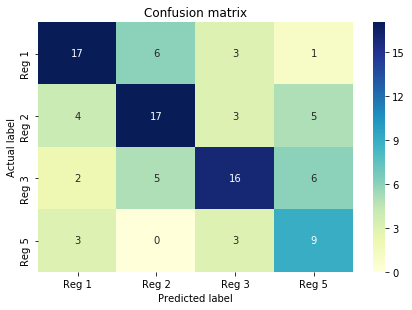

In [61]:
evaluate_performance(back_to_1_5(val_estimates), val_y)

# Add Regularization

## Set up NN

In [65]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 18, 30, 6

# Create random Tensors to hold inputs and outputs.
x = torch.FloatTensor(train_X)
y = torch.from_numpy(to_0_3(train_y))

val = torch.FloatTensor(val_X)
v_y = torch.from_numpy(to_0_3(val_y))

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

## Train NN

In [66]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.05)
train_loss = []
val_loss = []
for t in range(10000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    y_val_pred = model(val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss.append(loss)
    
    loss_v = loss_fn(y_val_pred, v_y)
    val_loss.append(loss_v)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 1.8159226179122925
1 1.8150924444198608
2 1.8142627477645874
3 1.8134349584579468
4 1.8126078844070435
5 1.8117822408676147
6 1.8109567165374756
7 1.8101338148117065
8 1.8093112707138062
9 1.8084890842437744
10 1.807668924331665
11 1.8068491220474243
12 1.8060318231582642
13 1.805213212966919
14 1.8043969869613647
15 1.8035815954208374
16 1.8027664422988892
17 1.8019535541534424
18 1.8011431694030762
19 1.8003333806991577
20 1.7995246648788452
21 1.7987174987792969
22 1.7979127168655396
23 1.797108769416809
24 1.7963050603866577
25 1.7955036163330078
26 1.7947022914886475
27 1.7939027547836304
28 1.7931056022644043
29 1.7923084497451782
30 1.7915135622024536
31 1.7907192707061768
32 1.789926528930664
33 1.7891329526901245
34 1.7883427143096924
35 1.787551760673523
36 1.786763310432434
37 1.7859748601913452
38 1.7851874828338623
39 1.784401535987854
40 1.7836146354675293
41 1.7828267812728882
42 1.7820408344268799
43 1.7812540531158447
44 1.7804701328277588
45 1.7796862125396729
46 1.

533 1.4419140815734863
534 1.4412920475006104
535 1.4406704902648926
536 1.4400501251220703
537 1.439429521560669
538 1.4388108253479004
539 1.4381928443908691
540 1.437574028968811
541 1.4369558095932007
542 1.4363383054733276
543 1.43572199344635
544 1.435105562210083
545 1.434489130973816
546 1.433873176574707
547 1.4332581758499146
548 1.432644009590149
549 1.4320299625396729
550 1.4314168691635132
551 1.4308046102523804
552 1.4301927089691162
553 1.4295806884765625
554 1.4289706945419312
555 1.4283607006072998
556 1.427750587463379
557 1.427141785621643
558 1.4265332221984863
559 1.4259241819381714
560 1.4253157377243042
561 1.424708366394043
562 1.4241013526916504
563 1.4234954118728638
564 1.4228883981704712
565 1.4222816228866577
566 1.421676754951477
567 1.421072244644165
568 1.4204685688018799
569 1.4198660850524902
570 1.4192625284194946
571 1.4186607599258423
572 1.4180577993392944
573 1.417455792427063
574 1.4168553352355957
575 1.4162546396255493
576 1.4156556129455566
57

1052 1.1854244470596313
1053 1.1850465536117554
1054 1.1846685409545898
1055 1.1842913627624512
1056 1.183915138244629
1057 1.1835402250289917
1058 1.1831649541854858
1059 1.18278968334198
1060 1.182415246963501
1061 1.1820420026779175
1062 1.1816678047180176
1063 1.1812940835952759
1064 1.1809216737747192
1065 1.180549144744873
1066 1.1801759004592896
1067 1.1798043251037598
1068 1.179432988166809
1069 1.1790622472763062
1070 1.1786911487579346
1071 1.1783208847045898
1072 1.1779519319534302
1073 1.1775827407836914
1074 1.1772136688232422
1075 1.1768450736999512
1076 1.1764769554138184
1077 1.1761091947555542
1078 1.17574143409729
1079 1.1753747463226318
1080 1.1750081777572632
1081 1.1746419668197632
1082 1.174275279045105
1083 1.1739094257354736
1084 1.173543095588684
1085 1.1731773614883423
1086 1.172812819480896
1087 1.1724480390548706
1088 1.1720831394195557
1089 1.1717191934585571
1090 1.171355128288269
1091 1.1709909439086914
1092 1.1706273555755615
1093 1.1702637672424316
1094

1402 1.0740162134170532
1403 1.0737628936767578
1404 1.073510766029358
1405 1.0732578039169312
1406 1.0730060338974
1407 1.0727542638778687
1408 1.0725030899047852
1409 1.0722529888153076
1410 1.0720030069351196
1411 1.0717540979385376
1412 1.0715045928955078
1413 1.0712560415267944
1414 1.0710086822509766
1415 1.0707601308822632
1416 1.070512056350708
1417 1.0702658891677856
1418 1.0700196027755737
1419 1.0697740316390991
1420 1.0695281028747559
1421 1.069283127784729
1422 1.0690385103225708
1423 1.0687943696975708
1424 1.06855046749115
1425 1.0683071613311768
1426 1.0680639743804932
1427 1.0678218603134155
1428 1.0675787925720215
1429 1.0673365592956543
1430 1.0670948028564453
1431 1.0668538808822632
1432 1.0666134357452393
1433 1.0663728713989258
1434 1.0661325454711914
1435 1.0658929347991943
1436 1.0656529664993286
1437 1.0654140710830688
1438 1.0651755332946777
1439 1.0649369955062866
1440 1.0646986961364746
1441 1.0644620656967163
1442 1.0642242431640625
1443 1.063988208770752
1

1920 0.9786083102226257
1921 0.9784784317016602
1922 0.9783501625061035
1923 0.9782202243804932
1924 0.978090763092041
1925 0.9779633283615112
1926 0.9778337478637695
1927 0.9777057766914368
1928 0.9775777459144592
1929 0.9774504899978638
1930 0.9773225784301758
1931 0.9771949648857117
1932 0.9770675897598267
1933 0.9769397377967834
1934 0.9768120646476746
1935 0.9766848683357239
1936 0.976557195186615
1937 0.9764299392700195
1938 0.9763030409812927
1939 0.9761760830879211
1940 0.9760491251945496
1941 0.9759223461151123
1942 0.9757964611053467
1943 0.9756703972816467
1944 0.9755441546440125
1945 0.9754177331924438
1946 0.9752913117408752
1947 0.975165069103241
1948 0.9750386476516724
1949 0.974912703037262
1950 0.9747877717018127
1951 0.9746618270874023
1952 0.9745370149612427
1953 0.9744117856025696
1954 0.9742864966392517
1955 0.9741619229316711
1956 0.9740371704101562
1957 0.9739131927490234
1958 0.9737874865531921
1959 0.9736636877059937
1960 0.9735407829284668
1961 0.9734163284301

2279 0.9421047568321228
2280 0.9420269131660461
2281 0.9419490098953247
2282 0.9418708682060242
2283 0.9417934417724609
2284 0.9417160749435425
2285 0.9416374564170837
2286 0.9415597915649414
2287 0.9414820671081543
2288 0.9414044618606567
2289 0.9413272738456726
2290 0.9412487149238586
2291 0.9411719441413879
2292 0.9410950541496277
2293 0.9410166144371033
2294 0.9409394860267639
2295 0.9408624172210693
2296 0.9407854080200195
2297 0.9407079815864563
2298 0.9406308531761169
2299 0.9405532479286194
2300 0.9404755234718323
2301 0.9403985738754272
2302 0.9403207898139954
2303 0.9402439594268799
2304 0.9401668310165405
2305 0.940090000629425
2306 0.9400121569633484
2307 0.9399343729019165
2308 0.9398580193519592
2309 0.9397799372673035
2310 0.9397027492523193
2311 0.9396257400512695
2312 0.9395480155944824
2313 0.9394699335098267
2314 0.9393928647041321
2315 0.9393150210380554
2316 0.9392378926277161
2317 0.9391615986824036
2318 0.9390843510627747
2319 0.9390088319778442
2320 0.9389308691

2790 0.9096679091453552
2791 0.9096182584762573
2792 0.9095696210861206
2793 0.9095209836959839
2794 0.9094721674919128
2795 0.909423291683197
2796 0.9093748927116394
2797 0.9093257188796997
2798 0.90927654504776
2799 0.9092280268669128
2800 0.9091792106628418
2801 0.9091309905052185
2802 0.909082293510437
2803 0.909034252166748
2804 0.9089850783348083
2805 0.9089372158050537
2806 0.9088889360427856
2807 0.9088411331176758
2808 0.908793568611145
2809 0.9087455868721008
2810 0.9086979627609253
2811 0.9086509346961975
2812 0.9086037278175354
2813 0.9085561633110046
2814 0.9085077047348022
2815 0.9084603786468506
2816 0.9084134101867676
2817 0.9083660244941711
2818 0.9083188772201538
2819 0.9082714915275574
2820 0.9082246422767639
2821 0.9081771373748779
2822 0.9081303477287292
2823 0.9080832004547119
2824 0.9080356359481812
2825 0.9079879522323608
2826 0.9079397916793823
2827 0.9078933000564575
2828 0.907845139503479
2829 0.9077980518341064
2830 0.9077504277229309
2831 0.9077044129371643

3164 0.8951110243797302
3165 0.8950798511505127
3166 0.8950484991073608
3167 0.8950170874595642
3168 0.894985556602478
3169 0.894954264163971
3170 0.89492267370224
3171 0.8948912024497986
3172 0.8948598504066467
3173 0.8948284983634949
3174 0.8947979211807251
3175 0.894766628742218
3176 0.894736111164093
3177 0.8947051167488098
3178 0.8946738243103027
3179 0.8946425914764404
3180 0.8946117162704468
3181 0.8945810198783875
3182 0.8945503830909729
3183 0.8945196270942688
3184 0.8944894075393677
3185 0.894459068775177
3186 0.8944287300109863
3187 0.8943979144096375
3188 0.8943670988082886
3189 0.894336998462677
3190 0.8943073153495789
3191 0.8942760825157166
3192 0.8942457437515259
3193 0.8942150473594666
3194 0.8941847681999207
3195 0.8941537141799927
3196 0.8941245675086975
3197 0.8940942287445068
3198 0.89406418800354
3199 0.8940332531929016
3200 0.8940037488937378
3201 0.8939729928970337
3202 0.8939422369003296
3203 0.8939108848571777
3204 0.893882155418396
3205 0.893851101398468
3206

3508 0.8848926424980164
3509 0.8848668336868286
3510 0.8848414421081543
3511 0.8848156929016113
3512 0.8847896456718445
3513 0.884763777256012
3514 0.8847383260726929
3515 0.8847126960754395
3516 0.8846880197525024
3517 0.8846628069877625
3518 0.8846368789672852
3519 0.8846108913421631
3520 0.884584903717041
3521 0.8845598697662354
3522 0.8845339417457581
3523 0.8845090270042419
3524 0.8844833970069885
3525 0.8844586610794067
3526 0.8844336867332458
3527 0.8844088912010193
3528 0.8843838572502136
3529 0.8843604326248169
3530 0.884334921836853
3531 0.8843106627464294
3532 0.8842857480049133
3533 0.8842605352401733
3534 0.8842360973358154
3535 0.8842115998268127
3536 0.8841862678527832
3537 0.8841608762741089
3538 0.8841367959976196
3539 0.8841121792793274
3540 0.884087085723877
3541 0.8840634226799011
3542 0.884038507938385
3543 0.8840136528015137
3544 0.8839889168739319
3545 0.8839635848999023
3546 0.8839392066001892
3547 0.8839160799980164
3548 0.8838917016983032
3549 0.88386684656143

3878 0.8770948648452759
3879 0.8770772814750671
3880 0.8770608901977539
3881 0.8770440816879272
3882 0.8770260214805603
3883 0.8770086169242859
3884 0.876991331577301
3885 0.8769744038581848
3886 0.8769575953483582
3887 0.8769412040710449
3888 0.8769249320030212
3889 0.8769073486328125
3890 0.8768897652626038
3891 0.8768725991249084
3892 0.8768557906150818
3893 0.8768395185470581
3894 0.8768227100372314
3895 0.8768053650856018
3896 0.8767876625061035
3897 0.8767715096473694
3898 0.8767544627189636
3899 0.876737654209137
3900 0.8767215609550476
3901 0.8767048120498657
3902 0.8766870498657227
3903 0.8766694664955139
3904 0.8766525983810425
3905 0.8766354918479919
3906 0.8766191005706787
3907 0.8766027688980103
3908 0.8765866756439209
3909 0.8765701651573181
3910 0.8765526413917542
3911 0.8765354156494141
3912 0.8765190243721008
3913 0.8765026330947876
3914 0.8764858245849609
3915 0.8764698505401611
3916 0.8764535188674927
3917 0.8764366507530212
3918 0.8764201402664185
3919 0.87640380859

4242 0.8719574809074402
4243 0.8719474673271179
4244 0.8719364404678345
4245 0.8719261884689331
4246 0.8719152808189392
4247 0.8719043731689453
4248 0.871893048286438
4249 0.871883749961853
4250 0.8718727827072144
4251 0.8718637228012085
4252 0.8718534708023071
4253 0.8718422055244446
4254 0.8718298077583313
4255 0.8718194961547852
4256 0.8718085885047913
4257 0.8717988133430481
4258 0.871788501739502
4259 0.8717779517173767
4260 0.8717663884162903
4261 0.8717561364173889
4262 0.8717458844184875
4263 0.8717349767684937
4264 0.8717256188392639
4265 0.8717159032821655
4266 0.8717060089111328
4267 0.871696412563324
4268 0.8716856241226196
4269 0.8716748356819153
4270 0.8716644048690796
4271 0.8716533780097961
4272 0.871641993522644
4273 0.8716313242912292
4274 0.8716214895248413
4275 0.8716110587120056
4276 0.871601402759552
4277 0.8715907335281372
4278 0.8715810179710388
4279 0.8715698719024658
4280 0.8715593218803406
4281 0.8715494275093079
4282 0.8715380430221558
4283 0.871527612209320

4602 0.8679916858673096
4603 0.8679811954498291
4604 0.8679701685905457
4605 0.8679599761962891
4606 0.8679484128952026
4607 0.8679373264312744
4608 0.8679265379905701
4609 0.8679159283638
4610 0.8679056763648987
4611 0.8678949475288391
4612 0.8678834438323975
4613 0.8678721189498901
4614 0.8678615093231201
4615 0.8678514957427979
4616 0.8678408265113831
4617 0.8678298592567444
4618 0.867819607257843
4619 0.8678092360496521
4620 0.8677992224693298
4621 0.8677894473075867
4622 0.8677788972854614
4623 0.867768406867981
4624 0.8677569031715393
4625 0.8677465915679932
4626 0.8677371144294739
4627 0.8677268624305725
4628 0.8677171468734741
4629 0.867705762386322
4630 0.8676961064338684
4631 0.8676849603652954
4632 0.8676742315292358
4633 0.8676640391349792
4634 0.8676537275314331
4635 0.8676444292068481
4636 0.8676360845565796
4637 0.8676279783248901
4638 0.8676182627677917
4639 0.8676090240478516
4640 0.8675992488861084
4641 0.8675892353057861
4642 0.867580771446228
4643 0.8675718903541565

4985 0.8653049468994141
4986 0.8652991056442261
4987 0.8652945756912231
4988 0.8652889132499695
4989 0.8652833104133606
4990 0.8652783036231995
4991 0.865272581577301
4992 0.8652666807174683
4993 0.8652615547180176
4994 0.8652557730674744
4995 0.8652501702308655
4996 0.8652448058128357
4997 0.8652394413948059
4998 0.8652341365814209
4999 0.8652288317680359
5000 0.8652224540710449
5001 0.8652178645133972
5002 0.8652114272117615
5003 0.8652064800262451
5004 0.8652005195617676
5005 0.8651959896087646
5006 0.8651905059814453
5007 0.8651849031448364
5008 0.8651796579360962
5009 0.865174412727356
5010 0.8651683330535889
5011 0.8651630282402039
5012 0.8651579022407532
5013 0.8651528358459473
5014 0.8651469349861145
5015 0.8651423454284668
5016 0.8651372194290161
5017 0.8651318550109863
5018 0.8651259541511536
5019 0.865119457244873
5020 0.8651139140129089
5021 0.8651089072227478
5022 0.8651039600372314
5023 0.8650988936424255
5024 0.8650936484336853
5025 0.8650881052017212
5026 0.865081965923

5357 0.8631147742271423
5358 0.863105833530426
5359 0.8630970120429993
5360 0.8630886077880859
5361 0.8630807399749756
5362 0.8630724549293518
5363 0.863064706325531
5364 0.8630562424659729
5365 0.8630475997924805
5366 0.8630385994911194
5367 0.8630300164222717
5368 0.8630211353302002
5369 0.8630133867263794
5370 0.8630053400993347
5371 0.8629963397979736
5372 0.8629878163337708
5373 0.8629792928695679
5374 0.86297208070755
5375 0.8629637360572815
5376 0.8629559874534607
5377 0.8629481196403503
5378 0.86294025182724
5379 0.8629315495491028
5380 0.8629229664802551
5381 0.8629142642021179
5382 0.8629068732261658
5383 0.8628985285758972
5384 0.8628897070884705
5385 0.8628826141357422
5386 0.8628750443458557
5387 0.8628669381141663
5388 0.8628594875335693
5389 0.8628523945808411
5390 0.862845242023468
5391 0.8628384470939636
5392 0.8628314137458801
5393 0.8628238439559937
5394 0.8628161549568176
5395 0.8628087043762207
5396 0.8628023862838745
5397 0.8627933263778687
5398 0.862785816192627


5881 0.8601239919662476
5882 0.8601202368736267
5883 0.860116720199585
5884 0.8601129055023193
5885 0.8601076602935791
5886 0.8601042628288269
5887 0.8601013422012329
5888 0.8600966930389404
5889 0.8600924611091614
5890 0.8600893616676331
5891 0.8600855469703674
5892 0.8600821495056152
5893 0.8600778579711914
5894 0.8600742220878601
5895 0.8600707650184631
5896 0.8600677251815796
5897 0.8600637316703796
5898 0.8600608110427856
5899 0.8600571751594543
5900 0.8600534200668335
5901 0.860049843788147
5902 0.8600469827651978
5903 0.8600440621376038
5904 0.8600406646728516
5905 0.8600379228591919
5906 0.8600342273712158
5907 0.8600297570228577
5908 0.8600261211395264
5909 0.8600221276283264
5910 0.8600184321403503
5911 0.8600150346755981
5912 0.8600106835365295
5913 0.860007643699646
5914 0.8600042462348938
5915 0.8600013852119446
5916 0.8599981665611267
5917 0.8599940538406372
5918 0.8599902987480164
5919 0.8599869012832642
5920 0.8599833250045776
5921 0.8599801063537598
5922 0.859976768493

6257 0.8584457039833069
6258 0.8584399819374084
6259 0.8584345579147339
6260 0.8584284782409668
6261 0.8584222793579102
6262 0.8584174513816833
6263 0.8584121465682983
6264 0.8584079742431641
6265 0.8584036231040955
6266 0.8583984375
6267 0.8583926558494568
6268 0.8583866357803345
6269 0.8583807349205017
6270 0.8583753108978271
6271 0.858370304107666
6272 0.858364462852478
6273 0.858361005783081
6274 0.8583563566207886
6275 0.8583518266677856
6276 0.858346700668335
6277 0.8583406209945679
6278 0.8583361506462097
6279 0.8583313226699829
6280 0.8583261370658875
6281 0.8583210706710815
6282 0.8583161234855652
6283 0.8583111763000488
6284 0.8583060503005981
6285 0.8583009243011475
6286 0.8582958579063416
6287 0.8582904934883118
6288 0.858284592628479
6289 0.8582791686058044
6290 0.8582742810249329
6291 0.8582701086997986
6292 0.8582659363746643
6293 0.8582600951194763
6294 0.8582563400268555
6295 0.8582518100738525
6296 0.8582473397254944
6297 0.8582425117492676
6298 0.8582374453544617
629

6615 0.8570423126220703
6616 0.8570393323898315
6617 0.8570367693901062
6618 0.8570353984832764
6619 0.857032835483551
6620 0.8570306897163391
6621 0.8570288419723511
6622 0.8570266962051392
6623 0.8570238351821899
6624 0.8570228219032288
6625 0.8570203185081482
6626 0.857016921043396
6627 0.8570141196250916
6628 0.8570102453231812
6629 0.8570080399513245
6630 0.8570054769515991
6631 0.8570036292076111
6632 0.8570014238357544
6633 0.856999397277832
6634 0.8569954633712769
6635 0.8569906949996948
6636 0.856987476348877
6637 0.8569847941398621
6638 0.8569819927215576
6639 0.8569798469543457
6640 0.8569769263267517
6641 0.8569748401641846
6642 0.8569711446762085
6643 0.856967568397522
6644 0.8569636344909668
6645 0.8569599986076355
6646 0.8569561243057251
6647 0.8569530248641968
6648 0.8569503426551819
6649 0.8569473028182983
6650 0.8569434285163879
6651 0.856938898563385
6652 0.8569341897964478
6653 0.8569307923316956
6654 0.856927216053009
6655 0.856923520565033
6656 0.8569191694259644


6999 0.8560450673103333
7000 0.8560426235198975
7001 0.8560391664505005
7002 0.8560363054275513
7003 0.8560343980789185
7004 0.8560328483581543
7005 0.8560318350791931
7006 0.8560307025909424
7007 0.8560275435447693
7008 0.8560246825218201
7009 0.8560215830802917
7010 0.8560185432434082
7011 0.8560158610343933
7012 0.8560133576393127
7013 0.8560110330581665
7014 0.8560086488723755
7015 0.85600745677948
7016 0.8560059666633606
7017 0.8560046553611755
7018 0.8560017347335815
7019 0.8559998869895935
7020 0.8559978008270264
7021 0.855995237827301
7022 0.8559936881065369
7023 0.8559914231300354
7024 0.8559901714324951
7025 0.8559885621070862
7026 0.8559860587120056
7027 0.8559832572937012
7028 0.8559807538986206
7029 0.8559778928756714
7030 0.8559746742248535
7031 0.8559726476669312
7032 0.8559702038764954
7033 0.85596764087677
7034 0.8559651970863342
7035 0.8559630513191223
7036 0.8559606671333313
7037 0.8559590578079224
7038 0.8559563159942627
7039 0.855954647064209
7040 0.855952739715576

7370 0.8554332256317139
7371 0.8554307818412781
7372 0.8554285168647766
7373 0.855427086353302
7374 0.8554254174232483
7375 0.8554244637489319
7376 0.8554233312606812
7377 0.8554232120513916
7378 0.8554219007492065
7379 0.8554203510284424
7380 0.8554177284240723
7381 0.855416476726532
7382 0.8554137945175171
7383 0.8554116487503052
7384 0.8554086685180664
7385 0.8554069995880127
7386 0.8554041981697083
7387 0.8554016947746277
7388 0.8553997874259949
7389 0.8553981781005859
7390 0.8553964495658875
7391 0.8553943634033203
7392 0.8553926944732666
7393 0.8553894758224487
7394 0.8553869128227234
7395 0.855384111404419
7396 0.8553816676139832
7397 0.8553801774978638
7398 0.8553791046142578
7399 0.855377733707428
7400 0.8553776741027832
7401 0.8553768992424011
7402 0.8553757071495056
7403 0.8553740382194519
7404 0.8553722500801086
7405 0.8553711771965027
7406 0.855370044708252
7407 0.8553675413131714
7408 0.8553653359413147
7409 0.8553637862205505
7410 0.8553611636161804
7411 0.85535973310470

7747 0.855072557926178
7748 0.8550702333450317
7749 0.8550688028335571
7750 0.8550669550895691
7751 0.8550655245780945
7752 0.8550649881362915
7753 0.8550647497177124
7754 0.8550641536712646
7755 0.8550643920898438
7756 0.8550627827644348
7757 0.8550628423690796
7758 0.8550617694854736
7759 0.8550597429275513
7760 0.8550599813461304
7761 0.8550587892532349
7762 0.8550588488578796
7763 0.8550571203231812
7764 0.8550560474395752
7765 0.8550539612770081
7766 0.8550524711608887
7767 0.8550522327423096
7768 0.8550510406494141
7769 0.8550506830215454
7770 0.8550500869750977
7771 0.8550496101379395
7772 0.8550493717193604
7773 0.8550480604171753
7774 0.8550478219985962
7775 0.8550469279289246
7776 0.855046272277832
7777 0.8550463318824768
7778 0.855046272277832
7779 0.8550457954406738
7780 0.8550447225570679
7781 0.8550443053245544
7782 0.8550436496734619
7783 0.8550432920455933
7784 0.8550428152084351
7785 0.8550429940223694
7786 0.8550425171852112
7787 0.8550431132316589
7788 0.855042874813

8125 0.8548256754875183
8126 0.8548253178596497
8127 0.8548251986503601
8128 0.854824960231781
8129 0.8548254370689392
8130 0.8548257350921631
8131 0.8548263311386108
8132 0.8548257946968079
8133 0.8548258543014526
8134 0.8548247218132019
8135 0.854823887348175
8136 0.854823648929596
8137 0.8548228740692139
8138 0.8548217415809631
8139 0.8548210859298706
8140 0.8548210263252258
8141 0.854821503162384
8142 0.8548228144645691
8143 0.8548224568367004
8144 0.8548217415809631
8145 0.8548213243484497
8146 0.8548221588134766
8147 0.8548223972320557
8148 0.8548218011856079
8149 0.8548199534416199
8150 0.8548195362091064
8151 0.8548187613487244
8152 0.8548189401626587
8153 0.854817807674408
8154 0.8548175692558289
8155 0.8548179268836975
8156 0.854816734790802
8157 0.8548175692558289
8158 0.8548176288604736
8159 0.8548161387443542
8160 0.8548159599304199
8161 0.8548160195350647
8162 0.8548160195350647
8163 0.8548150062561035
8164 0.8548146486282349
8165 0.8548150062561035
8166 0.854814708232879

8499 0.8547207117080688
8500 0.8547200560569763
8501 0.8547189831733704
8502 0.8547191619873047
8503 0.8547192215919495
8504 0.8547183871269226
8505 0.8547176718711853
8506 0.8547175526618958
8507 0.8547173142433167
8508 0.8547179698944092
8509 0.8547190427780151
8510 0.8547195792198181
8511 0.8547187447547913
8512 0.8547179102897644
8513 0.8547182679176331
8514 0.8547182679176331
8515 0.8547186851501465
8516 0.8547179698944092
8517 0.8547173738479614
8518 0.8547165393829346
8519 0.8547168970108032
8520 0.8547175526618958
8521 0.8547177314758301
8522 0.8547170758247375
8523 0.854716956615448
8524 0.8547165393829346
8525 0.8547153472900391
8526 0.85471510887146
8527 0.8547150492668152
8528 0.854715883731842
8529 0.8547162413597107
8530 0.8547165989875793
8531 0.8547176122665405
8532 0.8547187447547913
8533 0.8547191619873047
8534 0.8547194600105286
8535 0.8547210097312927
8536 0.8547199368476868
8537 0.8547194600105286
8538 0.8547188639640808
8539 0.8547179698944092
8540 0.8547167778015

8887 0.8547757863998413
8888 0.8547757267951965
8889 0.8547760248184204
8890 0.8547757863998413
8891 0.8547750115394592
8892 0.8547746539115906
8893 0.8547746539115906
8894 0.8547760844230652
8895 0.8547768592834473
8896 0.8547770380973816
8897 0.8547786474227905
8898 0.8547800779342651
8899 0.8547796607017517
8900 0.8547799587249756
8901 0.8547797203063965
8902 0.8547799587249756
8903 0.8547800183296204
8904 0.8547810912132263
8905 0.8547823429107666
8906 0.8547825813293457
8907 0.8547815680503845
8908 0.8547818660736084
8909 0.8547817468643188
8910 0.8547816276550293
8911 0.8547815084457397
8912 0.8547831177711487
8913 0.8547843098640442
8914 0.8547849059104919
8915 0.8547838926315308
8916 0.8547832369804382
8917 0.8547821640968323
8918 0.8547820448875427
8919 0.8547825813293457
8920 0.8547834753990173
8921 0.8547841310501099
8922 0.8547844886779785
8923 0.8547842502593994
8924 0.8547850251197815
8925 0.8547857999801636
8926 0.8547860980033875
8927 0.8547847867012024
8928 0.854783773

9257 0.8543734550476074
9258 0.8543701767921448
9259 0.8543656468391418
9260 0.8543608784675598
9261 0.8543559908866882
9262 0.8543522357940674
9263 0.8543485403060913
9264 0.8543447852134705
9265 0.8543416857719421
9266 0.8543397784233093
9267 0.8543362021446228
9268 0.8543335795402527
9269 0.8543301820755005
9270 0.8543251752853394
9271 0.8543213605880737
9272 0.8543177247047424
9273 0.8543124198913574
9274 0.8543082475662231
9275 0.8543025255203247
9276 0.8542987704277039
9277 0.8542957305908203
9278 0.8542916178703308
9279 0.8542879819869995
9280 0.854284942150116
9281 0.8542815446853638
9282 0.854278028011322
9283 0.8542749285697937
9284 0.854271650314331
9285 0.8542691469192505
9286 0.8542661070823669
9287 0.8542601466178894
9288 0.8542558550834656
9289 0.8542514443397522
9290 0.854248046875
9291 0.8542443513870239
9292 0.8542420268058777
9293 0.854238748550415
9294 0.8542361855506897
9295 0.8542335629463196
9296 0.8542303442955017
9297 0.8542275428771973
9298 0.8542248606681824


9610 0.8540800213813782
9611 0.8540807366371155
9612 0.8540791869163513
9613 0.8540794849395752
9614 0.8540796637535095
9615 0.8540814518928528
9616 0.8540819883346558
9617 0.8540809154510498
9618 0.8540799021720886
9619 0.8540803790092468
9620 0.8540797233581543
9621 0.8540784120559692
9622 0.8540787100791931
9623 0.8540781736373901
9624 0.8540772795677185
9625 0.8540778160095215
9626 0.8540775775909424
9627 0.8540766835212708
9628 0.8540770411491394
9629 0.8540768027305603
9630 0.8540769815444946
9631 0.8540772795677185
9632 0.8540778160095215
9633 0.8540764451026917
9634 0.8540759086608887
9635 0.8540744781494141
9636 0.8540734052658081
9637 0.8540725708007812
9638 0.854071855545044
9639 0.854072093963623
9640 0.8540722131729126
9641 0.854071855545044
9642 0.8540717959403992
9643 0.854071855545044
9644 0.8540709614753723
9645 0.8540707230567932
9646 0.854071319103241
9647 0.8540709614753723
9648 0.8540700078010559
9649 0.8540696501731873
9650 0.8540684580802917
9651 0.85406839847564

9981 0.8539870977401733
9982 0.8539856672286987
9983 0.8539841175079346
9984 0.8539828062057495
9985 0.8539822697639465
9986 0.8539817333221436
9987 0.853981077671051
9988 0.8539812564849854
9989 0.8539799451828003
9990 0.8539804816246033
9991 0.8539808392524719
9992 0.8539807796478271
9993 0.8539791107177734
9994 0.8539783358573914
9995 0.85397869348526
9996 0.8539794087409973
9997 0.8539804220199585
9998 0.8539807796478271
9999 0.853980541229248


In [67]:
scores = model(torch.FloatTensor(train_X))
scores_np = scores.detach().numpy()

estimates = np.argmax(scores_np, axis=1)

Misclassified samples: 116
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.78      0.75        92
           2       0.77      0.67      0.72       122
           3       0.73      0.67      0.70       102
           5       0.61      0.72      0.66        80

    accuracy                           0.71       396
   macro avg       0.71      0.71      0.71       396
weighted avg       0.71      0.71      0.71       396



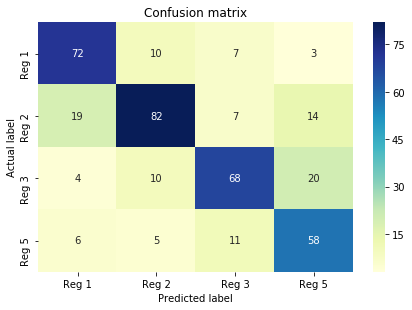

In [68]:
evaluate_performance(back_to_1_5(estimates), train_y)

### Validation

In [69]:
val_scores = model(torch.FloatTensor(val_X))
val_scores_np = val_scores.detach().numpy()

val_estimates = np.argmax(val_scores_np, axis=1)

Misclassified samples: 32
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.70      0.72        27
           2       0.79      0.79      0.79        28
           3       0.72      0.55      0.62        33
           5       0.43      0.75      0.55        12

    accuracy                           0.68       100
   macro avg       0.67      0.70      0.67       100
weighted avg       0.71      0.68      0.68       100



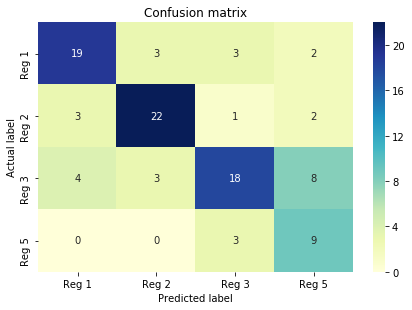

In [70]:
evaluate_performance(back_to_1_5(val_estimates), val_y)

### Bias-Variance Tradeoff

Text(0.5, 1.0, 'Training Loss')

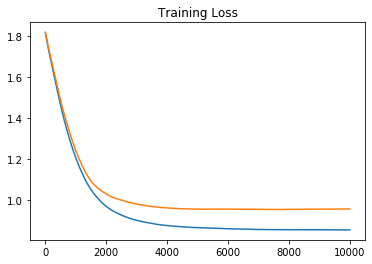

In [71]:
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title("Training Loss")

In [72]:
np.argmin(val_loss)

7681

## Retrain for the optimal number of epochs

In [73]:
# Use the nn package to define our model and loss function.
model2 = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

In [74]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=0.05)
train_loss = []
val_loss = []
for t in range(5600):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model2(x)
#     y_val_pred = model2(val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss.append(loss)
    
#     loss_v = loss_fn(y_val_pred, v_y)
#     val_loss.append(loss_v)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 1.8833101987838745
1 1.882265329360962
2 1.8812229633331299
3 1.8801835775375366
4 1.8791441917419434
5 1.878109097480774
6 1.8770744800567627
7 1.876044511795044
8 1.8750141859054565
9 1.8739876747131348
10 1.872961163520813
11 1.8719367980957031
12 1.8709139823913574
13 1.8698923587799072
14 1.8688749074935913
15 1.8678582906723022
16 1.8668413162231445
17 1.865830659866333
18 1.8648192882537842
19 1.863809585571289
20 1.862802505493164
21 1.8617959022521973
22 1.860791802406311
23 1.85979163646698
24 1.8587905168533325
25 1.8577922582626343
26 1.8567947149276733
27 1.8558011054992676
28 1.8548078536987305
29 1.8538165092468262
30 1.8528282642364502
31 1.8518434762954712
32 1.8508591651916504
33 1.8498775959014893
34 1.8488984107971191
35 1.8479210138320923
36 1.846946120262146
37 1.845973014831543
38 1.8450007438659668
39 1.8440302610397339
40 1.843058466911316
41 1.8420886993408203
42 1.8411192893981934
43 1.840152621269226
44 1.839186191558838
45 1.8382210731506348
46 1.83725512

395 1.5499746799468994
396 1.5492066144943237
397 1.5484378337860107
398 1.5476703643798828
399 1.5469012260437012
400 1.5461320877075195
401 1.5453623533248901
402 1.5445928573608398
403 1.5438218116760254
404 1.543051838874817
405 1.5422799587249756
406 1.5415087938308716
407 1.540737271308899
408 1.5399647951126099
409 1.5391933917999268
410 1.5384210348129272
411 1.537649154663086
412 1.5368762016296387
413 1.536104440689087
414 1.5353330373764038
415 1.534561276435852
416 1.5337889194488525
417 1.5330181121826172
418 1.5322450399398804
419 1.5314730405807495
420 1.5307011604309082
421 1.5299268960952759
422 1.5291531085968018
423 1.5283782482147217
424 1.5276037454605103
425 1.5268291234970093
426 1.5260547399520874
427 1.525281548500061
428 1.524507761001587
429 1.5237358808517456
430 1.5229623317718506
431 1.5221894979476929
432 1.5214189291000366
433 1.5206478834152222
434 1.519876480102539
435 1.5191056728363037
436 1.518335223197937
437 1.5175659656524658
438 1.51679456233978

805 1.2624239921569824
806 1.2618436813354492
807 1.261265516281128
808 1.2606877088546753
809 1.2601107358932495
810 1.2595335245132446
811 1.2589592933654785
812 1.2583837509155273
813 1.2578099966049194
814 1.2572370767593384
815 1.2566651105880737
816 1.2560949325561523
817 1.2555257081985474
818 1.254956841468811
819 1.2543896436691284
820 1.253821611404419
821 1.253257393836975
822 1.252692461013794
823 1.2521289587020874
824 1.2515664100646973
825 1.2510035037994385
826 1.2504427433013916
827 1.2498828172683716
828 1.2493231296539307
829 1.2487636804580688
830 1.2482072114944458
831 1.2476500272750854
832 1.2470941543579102
833 1.24653959274292
834 1.2459850311279297
835 1.245431900024414
836 1.2448805570602417
837 1.2443283796310425
838 1.243778944015503
839 1.2432292699813843
840 1.2426801919937134
841 1.2421315908432007
842 1.2415823936462402
843 1.2410335540771484
844 1.2404857873916626
845 1.2399389743804932
846 1.239392876625061
847 1.2388460636138916
848 1.238301157951355

1187 1.0948870182037354
1188 1.0945783853530884
1189 1.0942704677581787
1190 1.0939621925354004
1191 1.0936557054519653
1192 1.0933488607406616
1193 1.0930434465408325
1194 1.0927373170852661
1195 1.0924322605133057
1196 1.0921269655227661
1197 1.0918227434158325
1198 1.091518521308899
1199 1.091214656829834
1200 1.0909113883972168
1201 1.0906084775924683
1202 1.0903064012527466
1203 1.090004324913025
1204 1.0897020101547241
1205 1.089399814605713
1206 1.0890992879867554
1207 1.0887988805770874
1208 1.0884993076324463
1209 1.0881998538970947
1210 1.087900996208191
1211 1.0876023769378662
1212 1.0873041152954102
1213 1.0870064496994019
1214 1.0867087841033936
1215 1.086412787437439
1216 1.0861161947250366
1217 1.0858203172683716
1218 1.0855247974395752
1219 1.0852296352386475
1220 1.0849360227584839
1221 1.0846418142318726
1222 1.0843485593795776
1223 1.0840562582015991
1224 1.0837637186050415
1225 1.0834717750549316
1226 1.0831812620162964
1227 1.082890510559082
1228 1.082601547241211


1586 1.0035630464553833
1587 1.003394603729248
1588 1.0032249689102173
1589 1.0030560493469238
1590 1.002887487411499
1591 1.0027190446853638
1592 1.0025513172149658
1593 1.0023837089538574
1594 1.0022168159484863
1595 1.0020493268966675
1596 1.0018831491470337
1597 1.0017156600952148
1598 1.0015497207641602
1599 1.0013834238052368
1600 1.0012177228927612
1601 1.001051902770996
1602 1.0008862018585205
1603 1.0007209777832031
1604 1.0005552768707275
1605 1.000390648841858
1606 1.0002259016036987
1607 1.0000617504119873
1608 0.9998979568481445
1609 0.9997338056564331
1610 0.9995699524879456
1611 0.9994064569473267
1612 0.9992421269416809
1613 0.999079167842865
1614 0.9989166259765625
1615 0.9987542033195496
1616 0.9985923171043396
1617 0.9984309077262878
1618 0.9982692003250122
1619 0.9981083869934082
1620 0.9979469180107117
1621 0.9977864623069763
1622 0.997626006603241
1623 0.9974652528762817
1624 0.9973052144050598
1625 0.9971458315849304
1626 0.9969860911369324
1627 0.996825933456420

1991 0.951242208480835
1992 0.9511435627937317
1993 0.9510453939437866
1994 0.9509482383728027
1995 0.9508501887321472
1996 0.950752854347229
1997 0.9506546258926392
1998 0.9505569934844971
1999 0.9504591822624207
2000 0.9503614902496338
2001 0.9502642154693604
2002 0.950166642665863
2003 0.950070858001709
2004 0.9499742984771729
2005 0.9498770833015442
2006 0.9497804045677185
2007 0.9496843218803406
2008 0.9495880603790283
2009 0.9494933485984802
2010 0.9493982195854187
2011 0.9493032097816467
2012 0.9492089152336121
2013 0.9491139650344849
2014 0.9490193724632263
2015 0.9489250779151917
2016 0.9488304853439331
2017 0.9487370252609253
2018 0.9486438632011414
2019 0.9485499262809753
2020 0.948456883430481
2021 0.9483644366264343
2022 0.9482716917991638
2023 0.948178768157959
2024 0.9480865001678467
2025 0.9479935169219971
2026 0.9479014277458191
2027 0.9478098750114441
2028 0.9477182030677795
2029 0.9476265907287598
2030 0.9475358128547668
2031 0.9474449753761292
2032 0.947354316711425

2399 0.9196319580078125
2400 0.9195721745491028
2401 0.9195115566253662
2402 0.9194509983062744
2403 0.9193913340568542
2404 0.9193314909934998
2405 0.919270932674408
2406 0.9192101955413818
2407 0.9191499352455139
2408 0.9190894961357117
2409 0.9190279841423035
2410 0.9189679622650146
2411 0.9189066886901855
2412 0.918846845626831
2413 0.918785572052002
2414 0.9187255501747131
2415 0.9186646342277527
2416 0.91860431432724
2417 0.9185442924499512
2418 0.9184844493865967
2419 0.9184243679046631
2420 0.918364405632019
2421 0.9183039665222168
2422 0.9182441830635071
2423 0.918184220790863
2424 0.9181240200996399
2425 0.9180644750595093
2426 0.9180052876472473
2427 0.9179456830024719
2428 0.9178866744041443
2429 0.9178258180618286
2430 0.9177663922309875
2431 0.9177061915397644
2432 0.9176471829414368
2433 0.9175886511802673
2434 0.9175290465354919
2435 0.9174699187278748
2436 0.9174110889434814
2437 0.9173522591590881
2438 0.917293131351471
2439 0.9172341227531433
2440 0.9171750545501709


2799 0.899512529373169
2800 0.8994724154472351
2801 0.8994319438934326
2802 0.899392306804657
2803 0.8993526697158813
2804 0.8993119597434998
2805 0.8992725610733032
2806 0.8992323279380798
2807 0.8991934061050415
2808 0.8991538882255554
2809 0.8991141319274902
2810 0.8990751504898071
2811 0.8990356922149658
2812 0.8989959359169006
2813 0.8989568948745728
2814 0.898917019367218
2815 0.8988771438598633
2816 0.898837685585022
2817 0.8987993001937866
2818 0.8987607955932617
2819 0.8987218737602234
2820 0.898683488368988
2821 0.8986444473266602
2822 0.8986058831214905
2823 0.8985663652420044
2824 0.8985273838043213
2825 0.8984887003898621
2826 0.8984511494636536
2827 0.8984135389328003
2828 0.8983750939369202
2829 0.8983359932899475
2830 0.8982982635498047
2831 0.8982606530189514
2832 0.8982231020927429
2833 0.8981855511665344
2834 0.8981473445892334
2835 0.8981092572212219
2836 0.898070752620697
2837 0.8980342149734497
2838 0.8979968428611755
2839 0.8979582190513611
2840 0.897920608520507

3201 0.8860608339309692
3202 0.8860301971435547
3203 0.8859996795654297
3204 0.8859694004058838
3205 0.8859390020370483
3206 0.8859084248542786
3207 0.8858790397644043
3208 0.8858479857444763
3209 0.8858181834220886
3210 0.8857874870300293
3211 0.8857569694519043
3212 0.8857271075248718
3213 0.8856968879699707
3214 0.8856666088104248
3215 0.8856369256973267
3216 0.8856071829795837
3217 0.8855776786804199
3218 0.8855467438697815
3219 0.8855167031288147
3220 0.8854862451553345
3221 0.885456383228302
3222 0.8854262828826904
3223 0.8853972554206848
3224 0.8853672742843628
3225 0.8853376507759094
3226 0.8853079080581665
3227 0.8852776288986206
3228 0.8852478265762329
3229 0.8852181434631348
3230 0.8851887583732605
3231 0.8851591348648071
3232 0.8851288557052612
3233 0.8850995302200317
3234 0.8850694894790649
3235 0.8850407600402832
3236 0.8850117921829224
3237 0.8849822282791138
3238 0.8849524259567261
3239 0.8849234580993652
3240 0.8848942518234253
3241 0.884864866733551
3242 0.88483637571

3613 0.8763614296913147
3614 0.8763442635536194
3615 0.8763273358345032
3616 0.8763098120689392
3617 0.8762921690940857
3618 0.8762744665145874
3619 0.8762568235397339
3620 0.8762398362159729
3621 0.8762228488922119
3622 0.8762051463127136
3623 0.8761877417564392
3624 0.8761706352233887
3625 0.8761531710624695
3626 0.8761367201805115
3627 0.8761196136474609
3628 0.8761013150215149
3629 0.8760848641395569
3630 0.8760678172111511
3631 0.8760510087013245
3632 0.8760344386100769
3633 0.8760179281234741
3634 0.8760018944740295
3635 0.8759849667549133
3636 0.8759685754776001
3637 0.875951886177063
3638 0.8759354948997498
3639 0.8759192824363708
3640 0.8759034276008606
3641 0.8758875727653503
3642 0.8758711218833923
3643 0.8758541941642761
3644 0.8758382201194763
3645 0.8758218884468079
3646 0.8758058547973633
3647 0.8757897019386292
3648 0.8757731318473816
3649 0.8757579922676086
3650 0.8757416009902954
3651 0.8757261633872986
3652 0.8757106065750122
3653 0.875694215297699
3654 0.87567830085

4013 0.8699159026145935
4014 0.869901716709137
4015 0.8698870539665222
4016 0.8698716759681702
4017 0.8698568344116211
4018 0.8698415756225586
4019 0.8698269724845886
4020 0.8698117733001709
4021 0.8697977066040039
4022 0.8697822690010071
4023 0.8697687983512878
4024 0.8697541952133179
4025 0.8697395920753479
4026 0.8697243332862854
4027 0.8697099685668945
4028 0.8696940541267395
4029 0.869678795337677
4030 0.8696638941764832
4031 0.8696486949920654
4032 0.8696346282958984
4033 0.8696194887161255
4034 0.869605302810669
4035 0.8695905208587646
4036 0.8695763349533081
4037 0.8695622682571411
4038 0.8695478439331055
4039 0.8695330619812012
4040 0.8695187568664551
4041 0.8695036768913269
4042 0.8694890141487122
4043 0.8694742918014526
4044 0.8694600462913513
4045 0.8694460391998291
4046 0.8694323897361755
4047 0.8694181442260742
4048 0.8694044351577759
4049 0.8693901896476746
4050 0.8693758845329285
4051 0.8693612813949585
4052 0.8693462610244751
4053 0.8693305253982544
4054 0.869315505027

4447 0.8652353882789612
4448 0.865226149559021
4449 0.8652170300483704
4450 0.8652073740959167
4451 0.8651987910270691
4452 0.8651890754699707
4453 0.8651807904243469
4454 0.8651718497276306
4455 0.8651631474494934
4456 0.8651547431945801
4457 0.8651461601257324
4458 0.8651377558708191
4459 0.8651278614997864
4460 0.8651201725006104
4461 0.8651113510131836
4462 0.8651025891304016
4463 0.8650942444801331
4464 0.8650856614112854
4465 0.8650776743888855
4466 0.8650693893432617
4467 0.865061342716217
4468 0.865053117275238
4469 0.8650451898574829
4470 0.8650367856025696
4471 0.8650278449058533
4472 0.8650189638137817
4473 0.8650100231170654
4474 0.8650020956993103
4475 0.8649946451187134
4476 0.8649876713752747
4477 0.8649787306785583
4478 0.8649709820747375
4479 0.8649616241455078
4480 0.864952027797699
4481 0.8649429082870483
4482 0.8649352788925171
4483 0.864926815032959
4484 0.8649181127548218
4485 0.8649109601974487
4486 0.8649024367332458
4487 0.8648939728736877
4488 0.86488521099090

4844 0.8622016310691833
4845 0.8621955513954163
4846 0.8621898889541626
4847 0.862183153629303
4848 0.8621774315834045
4849 0.8621710538864136
4850 0.8621652126312256
4851 0.8621595501899719
4852 0.8621545433998108
4853 0.8621487617492676
4854 0.8621442914009094
4855 0.8621386885643005
4856 0.8621334433555603
4857 0.8621278405189514
4858 0.862122654914856
4859 0.8621158599853516
4860 0.8621101975440979
4861 0.8621042370796204
4862 0.8620983958244324
4863 0.8620928525924683
4864 0.862086832523346
4865 0.8620816469192505
4866 0.8620758056640625
4867 0.8620710372924805
4868 0.8620650768280029
4869 0.8620597124099731
4870 0.8620544672012329
4871 0.8620486259460449
4872 0.8620432019233704
4873 0.862035870552063
4874 0.8620305061340332
4875 0.86202472448349
4876 0.8620187044143677
4877 0.8620126843452454
4878 0.8620067834854126
4879 0.8620017170906067
4880 0.8619953989982605
4881 0.8619900941848755
4882 0.8619862794876099
4883 0.8619791865348816
4884 0.861973762512207
4885 0.8619680404663086

5261 0.8600548505783081
5262 0.8600496053695679
5263 0.8600444793701172
5264 0.860039234161377
5265 0.8600333333015442
5266 0.8600271940231323
5267 0.8600213527679443
5268 0.860015869140625
5269 0.8600115776062012
5270 0.8600058555603027
5271 0.8600016832351685
5272 0.859996497631073
5273 0.8599913716316223
5274 0.8599851131439209
5275 0.8599808812141418
5276 0.8599755764007568
5277 0.8599710464477539
5278 0.8599668741226196
5279 0.8599618673324585
5280 0.8599569797515869
5281 0.859951913356781
5282 0.8599473834037781
5283 0.8599427342414856
5284 0.8599384427070618
5285 0.8599342703819275
5286 0.859928548336029
5287 0.8599245548248291
5288 0.8599194884300232
5289 0.859915018081665
5290 0.8599109053611755
5291 0.8599056601524353
5292 0.8599017262458801
5293 0.8598970174789429
5294 0.8598921298980713
5295 0.8598878383636475
5296 0.8598830103874207
5297 0.8598781824111938
5298 0.8598735332489014
5299 0.8598690629005432
5300 0.8598640561103821
5301 0.8598591685295105
5302 0.859854936599731

In [75]:
val_scores = model(torch.FloatTensor(val_X))
val_scores_np = val_scores.detach().numpy()

val_estimates = np.argmax(val_scores_np, axis=1)

Misclassified samples: 32
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.70      0.72        27
           2       0.79      0.79      0.79        28
           3       0.72      0.55      0.62        33
           5       0.43      0.75      0.55        12

    accuracy                           0.68       100
   macro avg       0.67      0.70      0.67       100
weighted avg       0.71      0.68      0.68       100



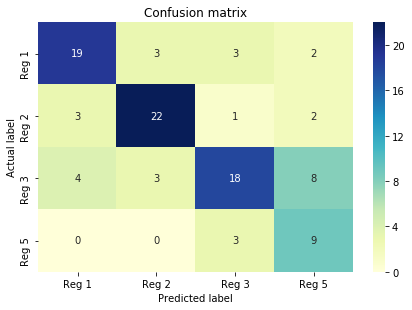

In [76]:
evaluate_performance(back_to_1_5(val_estimates), val_y)